In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.backends
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
import anndata as an
import scipy



In [2]:
# Enter the name of your input file here
inputFile = "seurat.txt"
# Input parameters
nGene = 300
nCell = 3

try:
    os.stat("ComplexityPlots")
except:
    os.mkdir("ComplexityPlots")
    
# Read in DGE Files    
fileNames = pd.read_csv(inputFile, sep = "\t")
fileNames

,Sample,DGE SilePath,Reads SilePath,Soup
0,AE1,L:/Duncan/MZCoculture/DGEs/AE1_20220307_DGE.UM...,L:/Duncan/MZCoculture/DGEs/AE1_20220307_readsS...,L:/Duncan/MZCoculture/DGEs/S1_20220307_soup.txt
1,AE2,L:/Duncan/MZCoculture/DGEs/AE2_20220307_DGE.UM...,L:/Duncan/MZCoculture/DGEs/AE2_20220307_readsS...,L:/Duncan/MZCoculture/DGEs/S1_20220307_soup.txt
2,AE3,L:/Duncan/MZCoculture/DGEs/AE3_20220307_DGE.UM...,L:/Duncan/MZCoculture/DGEs/AE3_20220307_readsS...,L:/Duncan/MZCoculture/DGEs/S1_20220307_soup.txt
3,AE10,L:/Duncan/MZCoculture/DGEs/AE10_20220506_DGE.U...,L:/Duncan/MZCoculture/DGEs/AE10_20220506_reads...,L:/Duncan/MZCoculture/DGEs/S1_20220307_soup.txt


In [3]:
tic = time.time()
first = True
for i in range(0,fileNames.shape[0]):
        
    # read and print sample name
    sampName = str(fileNames.Sample.iloc[i])
    print(sampName)
        
    # read in DGE and readCounts files, calculate nUMI
    cells = pd.read_csv(fileNames.values[i,1], index_col = 0, header = 0, delim_whitespace = True)
    nUMIs = cells.sum(axis = 0)
    readCounts = pd.read_csv(fileNames.values[i,2], index_col = 0, header = 0, delim_whitespace = True)
    readCounts = readCounts.reindex(index = list(cells))
    cells = cells.loc[~cells.index.duplicated(),:]    
    cells

    # plotting 
    spam = plt.figure()
    plt.rcParams['figure.figsize'] = [7,8]
    plt.plot(readCounts['ExonReads'], nUMIs, 'ko')
    plt.xlabel('Total Reads')
    plt.ylabel('Number of UMIs')
    plt.title(str(sampName) + " Complexity")  
    regr = linear_model.LinearRegression()
    regr.fit(X = nUMIs.values.reshape(-1,1), y = readCounts['ExonReads'].values)
    plt.plot(X = nUMIs.values.reshape(-1,1), Y = regr.predict(nUMIs.values.reshape(-1,1)))
    c = np.array2string(regr.coef_[0])
    plt.annotate("Complexity = " + c, (0,plt.ylim()[1]*.95))
    plt.savefig(fname = "ComplexityPlots/" + str(sampName) + '.png')
    plt.close()
        
    # filter by nGene
    keepcells = (cells.values>0).sum(axis = 0) > nGene
    keepgenes = (cells.values > 0).sum(axis = 1) > nCell
    cells = cells.loc[keepgenes, keepcells]
        
    readCounts = readCounts[:][keepcells]
    n = cells.shape[1]

    # rename columns of data frame to prevent barcode collisions
    identsadd = [sampName]*n
    index = [identsadd[i] + "_" + str(i) for i in range(0, len(identsadd))]
    cells.columns = index
    bcs = readCounts.index.values
    print(len(bcs))
    
    if first:
        cellsAll = cells.copy()
        readCountsAll = readCounts.copy()
        bcsAll= bcs.copy()
        first = False
        idents_all = identsadd

    else:
        cellsAll = pd.DataFrame.join(cellsAll, cells, how = 'outer')
        readCountsAll = readCountsAll.append(readCounts)
        bcsAll = np.append(bcsAll, bcs)
        idents_all = np.append(idents_all, identsadd)
        
toc = time.time()
print(toc - tic)
cellsAll = cellsAll.fillna(0)
cellsAll = cellsAll.reset_index()



AE1
3502
AE2
2871
AE3
3348
AE10
191
165.10019540786743


In [4]:
import pyarrow.feather
pyarrow.feather.write_feather(cellsAll, 'cellsAll.feather')  
pyarrow.feather.write_feather(readCountsAll, 'readCountsAll.feather')
np.savetxt('bcs.txt', bcsAll, fmt = "%s")

In [5]:
import sys
sys.path.append('../')
from functions import *

# read in and fix data
cells = pd.read_feather('cellsAll.feather')
cells.index = cells.loc[:, 'Gene']
cells = cells.drop('Gene', axis = 1)

filtered out 334 genes that are detected in less than 3 cells
filtered out 10 cells that have less than 300 genes expressed
AnnData object with n_obs × n_vars = 9902 × 14357
    obs: 'orig', 'bc', 'n_genes'
    var: 'n_cells'
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    Gene indices [5649, 14339, 14340] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:02)
regressing out n_counts


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig' as categorical


    finished (0:01:16)
linear scaling
computing PCA
    with n_comps=50
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:54)
    computed connectivities (0:00:05)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:00)
computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:48)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)


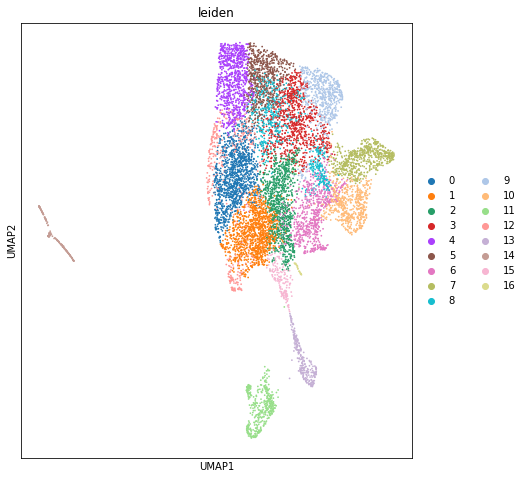

In [6]:
# SCANPY
sc.settings.verbosity = 4
adata = an.AnnData(cells.values.transpose())
adata.var_names = cells.index
adata.obs_names = cells.columns
bcs = np.loadtxt('bcs.txt', dtype = str)
adata.obs['orig'] =[x.split('_')[0] for x in adata.obs_names]
adata.obs['bc']= bcs
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata
sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.filter_cells(adata, min_genes = 300)
print(adata)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata = process(adata)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


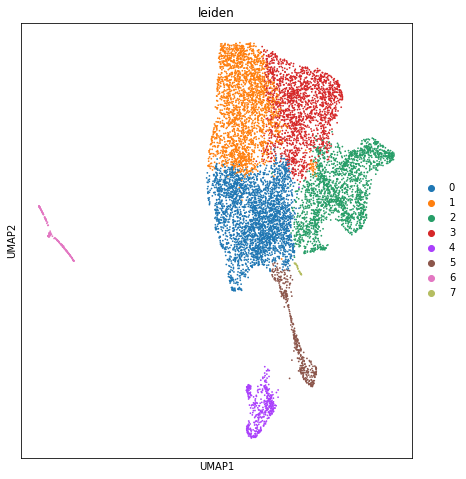

In [7]:
sc.tl.leiden(adata, resolution = .3)
sc.pl.umap(adata, color = 'leiden')

In [8]:
getgenes(adata, ['4']).head(10)

,LogFC,pct1,pct2,pval,pval_adj
Gene,,,,,
S100a9,4.427254,0.990453,0.218707,2.781604e-305,8.581250e-302
S100a8,4.166629,0.983294,0.184330,4.053627e-295,1.250544e-291
Ngp,3.910037,0.565632,0.054097,1.150015e-63,3.547796e-60
Ltf,3.472262,0.279236,0.037435,5.377755e-25,1.659038e-21
Lcn2,3.324224,0.739857,0.039755,5.075128e-107,1.565677e-103
Retnlg,3.280441,0.601432,0.054940,2.020098e-71,6.232002e-68
Mmp9,3.232785,0.840095,0.035432,3.736467e-147,1.152700e-143
Camp,2.909205,0.441527,0.028999,3.265896e-47,1.007529e-43
Mmp8,2.884405,0.675418,0.027839,4.242803e-91,1.308905e-87


In [9]:
getgenes(adata, ['6']).head(10)

,LogFC,pct1,pct2,pval,pval_adj
Gene,,,,,
Fos,2.884518,0.629834,0.022426,4.101141e-35,1.519473e-31
Krt5,2.794770,0.464088,0.000514,1.614023e-24,5.979956e-21
Gm26384,2.782799,0.928177,0.000000,2.588749e-85,9.591314e-82
Krt13,2.715838,0.447514,0.000000,9.690579e-24,3.590360e-20
Gm24187,2.658496,0.784530,0.002469,3.812003e-53,1.412347e-49
Krt19,2.522581,0.475138,0.000000,4.870997e-25,1.804704e-21
Tpsab1,2.475070,0.314917,0.000000,1.574320e-15,5.832854e-12
Gm10036,2.390109,0.845304,0.008538,2.663001e-65,9.866417e-62
Dsp,2.339923,0.458564,0.001337,5.059342e-24,1.874486e-20


In [10]:
getgenes(adata, ['7']).head(10)

,LogFC,pct1,pct2,pval,pval_adj
Gene,,,,,
Mcpt8,5.020252,0.791667,0.030067,6.034196e-09,1.717332e-05
Prss34,4.981199,0.791667,0.028245,1.079595e-08,3.072528e-05
Ccl6,3.521369,0.791667,0.086758,4.191095e-08,1.192786e-04
Cpa3,3.194659,0.666667,0.009617,1.136748e-06,3.235184e-03
Ifitm1,3.061610,0.833333,0.014072,5.145479e-09,1.464403e-05
Ccl9,3.023178,0.916667,0.034420,2.637720e-11,7.506950e-08
Ctsg,2.984812,0.541667,0.006074,4.324859e-05,1.230855e-01
Fcer1a,2.833103,0.541667,0.007593,7.166748e-05,2.039656e-01
Hdc,2.756559,0.875000,0.014983,1.347793e-09,3.835818e-06


extracting highly variable genes
    Gene indices [847, 5649, 14319, 14339, 14340] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:02)
regressing out n_counts
    finished (0:01:20)
linear scaling
computing PCA
    with n_comps=50
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:01)
    computed connectivities (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


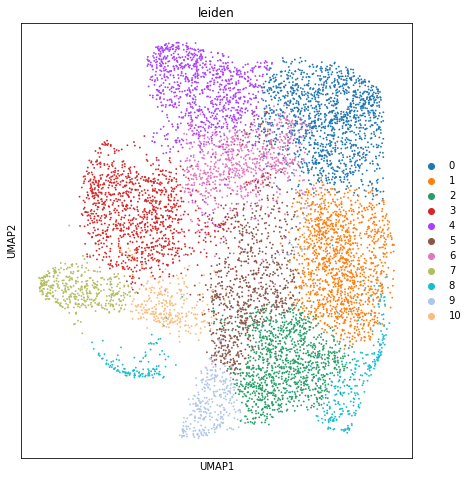

In [11]:
adata2 = removecluster(adata, ['4', '5', '6', '7'])

In [12]:
df = getgenes(adata2, ['AE3', 'AE10'], field = 'orig').sort_values(by = 'pval')

In [13]:
df[df.LogFC < 0].head(60)

,LogFC,pct1,pct2,pval,pval_adj
Gene,,,,,
Gzmb,-1.360172,0.183833,0.612115,0.000000e+00,0.000000e+00
Hspa9,-0.721196,0.294654,0.690415,3.217452e-296,2.892490e-293
Ccng1,-0.808244,0.258801,0.653760,1.957203e-287,1.759525e-284
Pa2g4,-0.702359,0.345828,0.718637,4.752770e-277,4.272740e-274
Serpine2,-0.860878,0.048892,0.342798,4.770933e-275,4.289068e-272
Tcp1,-0.635736,0.395698,0.765617,5.226331e-273,4.698472e-270
Nme1,-0.658894,0.359192,0.735157,3.739467e-269,3.361781e-266
Phb2,-0.629595,0.307692,0.690931,6.928854e-263,6.229039e-260
Atp5b,-0.645193,0.601043,0.870246,2.470624e-260,2.221091e-257


In [14]:
import pyarrow.feather
def seuratExport(adata, fname):
    df = pd.DataFrame(adata.raw.X.transpose())
    df.columns = adata.obs_names
    df.index = adata.raw.var_names
    df = df.reset_index()
    pyarrow.feather.write_feather(df, fname + '.feather') 
    adata.obs.to_csv(fname + '_meta.txt')
    
seuratExport(adata2, 'MZCO')